# Imports

In [1]:
import comet_ml
from comet_ml import Experiment
import torch
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch import nn
import matplotlib.pyplot as plt

In [2]:
import transformers
from transformers import *
import numpy as np
from datasets import load_dataset
import evaluate
from tqdm import tqdm

comet_ml is installed but `COMET_API_KEY` is not set.
/Users/milosz/opt/miniconda3/envs/pt/lib/python3.9/site-packages/transformers/generation_utils.py:24: FutureWarning: Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import GenerationMixin` instead.
  warnings.warn(


In [3]:
from datasets import load_dataset
import datasets

from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import AutoTokenizer, Trainer, TrainingArguments, AutoModelForSequenceClassification, DataCollatorWithPadding

In [4]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("mps")
print("Device:", device)

Device: mps


In [5]:
RANDOM_SEED = 42
VALIDATION_PERCENTAGE = 10
# PRE_TRAINED_MODEL_NAME = 'distilbert-base-uncased'
# PRE_TRAINED_MODEL_NAME = 'distilbert-base-uncased-finetuned-sst-2-english'
# PRE_TRAINED_MODEL_NAME = "bert-base-uncased"
PRE_TRAINED_MODEL_NAME = "nlptown/bert-base-multilingual-uncased-sentiment"

# Load and prepare data

In [6]:
full_train_dataset = load_dataset("csv", data_files="p6/train_data.csv")

train_dataset, valid_dataset = datasets.load_dataset("csv", data_files="p6/train_data.csv", split=[
    datasets.ReadInstruction('train', to=100-VALIDATION_PERCENTAGE, unit='%'),
    datasets.ReadInstruction('train', from_=-VALIDATION_PERCENTAGE, unit='%'),
])

test_dataset = load_dataset("csv", data_files="p6/test_data.csv", column_names=['review'])

Using custom data configuration default-09e2066563176d94
Found cached dataset csv (/Users/milosz/.cache/huggingface/datasets/csv/default-09e2066563176d94/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-09e2066563176d94
Found cached dataset csv (/Users/milosz/.cache/huggingface/datasets/csv/default-09e2066563176d94/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)


  0%|          | 0/2 [00:00<?, ?it/s]

Using custom data configuration default-87d9d524b2970477
Found cached dataset csv (/Users/milosz/.cache/huggingface/datasets/csv/default-87d9d524b2970477/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)


  0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
# rename label column
full_train_dataset = full_train_dataset.rename_column('rating', 'label')
train_dataset = train_dataset.rename_column('rating', 'label')
valid_dataset = valid_dataset.rename_column('rating', 'label')

In [8]:
print(full_train_dataset)

DatasetDict({
    train: Dataset({
        features: ['review', 'label'],
        num_rows: 16392
    })
})


In [9]:
print(train_dataset)

Dataset({
    features: ['review', 'label'],
    num_rows: 14753
})


In [10]:
print(valid_dataset)

Dataset({
    features: ['review', 'label'],
    num_rows: 1639
})


In [11]:
print(test_dataset)

DatasetDict({
    train: Dataset({
        features: ['review'],
        num_rows: 4099
    })
})


(array([1137.,    0., 1434.,    0.,    0., 1747.,    0., 4831.,    0.,
        7243.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

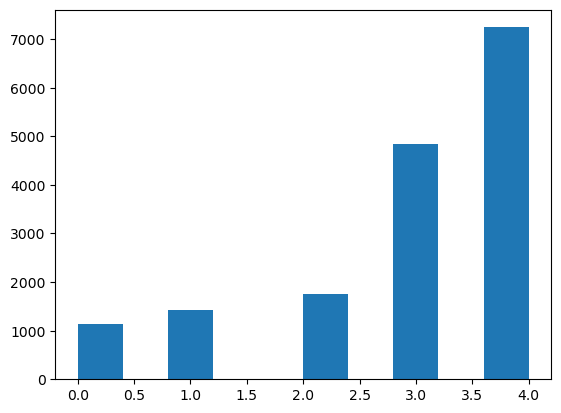

In [12]:
plt.hist(full_train_dataset['train']['label'])

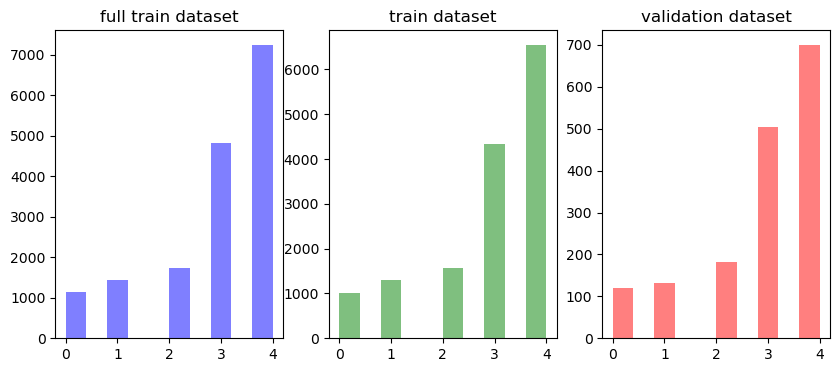

In [13]:
# Create a 3x1 grid of subplots
fig, axs = plt.subplots(1, 3, figsize=(10,4))

# Plot the first histogram in the first subplot
axs[0].hist(full_train_dataset['train']['label'], color='blue', alpha=0.5)
axs[0].set_title('full train dataset')

# Plot the second histogram in the second subplot
axs[1].hist(train_dataset['label'], color='green', alpha=0.5)
axs[1].set_title('train dataset')

# Plot the third histogram in the third subplot
axs[2].hist(valid_dataset['label'], color='red', alpha=0.5)
axs[2].set_title('validation dataset')

plt.show()

## Tokenization

In [14]:
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

def tokenize_function(data):
    return tokenizer(data["review"], padding="max_length", truncation=True)


tokenized_train_df = train_dataset.map(tokenize_function, batched=True)
tokenized_valid_df = valid_dataset.map(tokenize_function, batched=True)

tokenized_train_df = tokenized_train_df.remove_columns(['review'])
tokenized_valid_df = tokenized_valid_df.remove_columns(['review'])

tokenized_train_df.set_format("torch")
tokenized_valid_df.set_format("torch")

train_df = tokenized_train_df.shuffle(seed=RANDOM_SEED).select(range(200))
valid_df = tokenized_valid_df.shuffle(seed=RANDOM_SEED).select(range(100))
# train_df = tokenized_train_df
# valid_df = tokenized_valid_df

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

loading configuration file config.json from cache at /Users/milosz/.cache/huggingface/hub/models--nlptown--bert-base-multilingual-uncased-sentiment/snapshots/e06857fdb0325a7798a8fc361b417dfeec3a3b98/config.json
Model config BertConfig {
  "_name_or_path": "nlptown/bert-base-multilingual-uncased-sentiment",
  "_num_labels": 5,
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "finetuning_task": "sentiment-analysis",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "1 star",
    "1": "2 stars",
    "2": "3 stars",
    "3": "4 stars",
    "4": "5 stars"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "1 star": 0,
    "2 stars": 1,
    "3 stars": 2,
    "4 stars": 3,
    "5 stars": 4
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads"

In [15]:
print(train_df)

Dataset({
    features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 200
})


In [16]:
print(valid_df)

Dataset({
    features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 100
})


# Define model

In [17]:
# model = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(
    PRE_TRAINED_MODEL_NAME, num_labels=5
)

loading configuration file config.json from cache at /Users/milosz/.cache/huggingface/hub/models--nlptown--bert-base-multilingual-uncased-sentiment/snapshots/e06857fdb0325a7798a8fc361b417dfeec3a3b98/config.json
Model config BertConfig {
  "_name_or_path": "nlptown/bert-base-multilingual-uncased-sentiment",
  "_num_labels": 5,
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "finetuning_task": "sentiment-analysis",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "1 star",
    "1": "2 stars",
    "2": "3 stars",
    "3": "4 stars",
    "4": "5 stars"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "1 star": 0,
    "2 stars": 1,
    "3 stars": 2,
    "4 stars": 3,
    "5 stars": 4
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads"

In [18]:
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=16)
eval_dataloader = DataLoader(valid_dataset, batch_size=16)

In [19]:
optimizer = Adam(model.parameters(), lr=5e-5)
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [21]:
num_epochs = 3
loss_fun = nn.CrossEntropyLoss()

for epoch in range(num_epochs):
    losses = []
    for batch in tqdm(train_dataloader):

        labels = batch["label"].to(device)
        # batch = {"attention_mask": batch['attention_mask'].to(device), "input_ids": batch['input_ids'].to(device)}#, "token_type_ids":batch['token_type_ids'].to(device)}
        outputs = model(**batch)
        loss = loss_fun(outputs.logits, labels)
        loss.backward()

        optimizer.step()
#         lr_scheduler.step()
        optimizer.zero_grad()
#         progress_bar.update(1)
        losses.append(loss.item())
    print(np.mean(losses))

# trenowanie tego modelu zajmuje bardzo duzo czasu (godziny na kilka epok)

  0%|          | 0/923 [00:00<?, ?it/s]


TypeError: forward() got an unexpected keyword argument 'review'